In [381]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE # wrapper method pour choisir les features
from sklearn.linear_model import RidgeClassifierCV

from sklearn.preprocessing import OneHotEncoder
import pickle

import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
#from mlflow.models.signature import infer_signature

#Export new_df_test => sera utilisé pour la prédiction du modele avec fastapi


In [333]:
df_train= pd.read_feather("../../datasets/train_2.feather")
df_test = pd.read_feather("../../datasets/test_2.feather")
df_train.drop(df_train[df_train['CODE_GENDER']=='XNA'].index,axis=0, inplace = True)
#df_train.shape #confirmation de la suppression des 4 lignes

In [334]:
for col_na in df_train.isna().sum()[df_train.isna().sum() > 0 ].index: 
    print(col_na,df_train[col_na].dtype)
    if df_train[col_na].dtype =='object':
        df_train[col_na] = df_train[col_na].fillna(df_train[col_na].mode()) # var categ val mqte => mot le plus fréquent
    else :
        df_train[col_na] = df_train[col_na].fillna(df_train[col_na].median()) # val mqtes => mediane
df_train.isna().sum().sum()

AMT_ANNUITY float64
AMT_GOODS_PRICE float64
NAME_TYPE_SUITE object
CNT_FAM_MEMBERS float64
EXT_SOURCE_2 float64
EXT_SOURCE_3 float64
OBS_30_CNT_SOCIAL_CIRCLE float64
DEF_30_CNT_SOCIAL_CIRCLE float64
OBS_60_CNT_SOCIAL_CIRCLE float64
DEF_60_CNT_SOCIAL_CIRCLE float64
DAYS_LAST_PHONE_CHANGE float64
AMT_REQ_CREDIT_BUREAU_HOUR float64
AMT_REQ_CREDIT_BUREAU_DAY float64
AMT_REQ_CREDIT_BUREAU_WEEK float64
AMT_REQ_CREDIT_BUREAU_MON float64
AMT_REQ_CREDIT_BUREAU_QRT float64
AMT_REQ_CREDIT_BUREAU_YEAR float64


1292

In [335]:
X_train,X_test,y_train,y_test = train_test_split(df_train.drop(['TARGET'], axis =1),
                                                 df_train['TARGET'],
                                                test_size=0.3,
                                                random_state=42)



Nombre optimal de features avec RFE => recursive feature elimination

#https://machinelearningmastery.com/rfe-feature-selection-in-python/
rfe_selector = RFE(estimator = RidgeClassifierCV(),n_features_to_select=70, step=10, verbose = 5)
rfe_selector

rfe_selector.fit(X_tr_scaled,y_train) #sur données mise à l'échelle
rfe_support = rfe_selector.get_support()
rfe_feature = X_train.loc[:,rfe_support].columns.to_list()
print(str(len(rfe_feature)),'selected features')

Pipeline

In [365]:
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
import mlflow.sklearn
#from mlflow.models.signature import infer_signature

In [366]:
ct = ColumnTransformer([('one-hot-encoder', OneHotEncoder(), ar)], remainder='passthrough')
ct.fit(df_train) #https://vitalflux.com/one-hot-encoding-concepts-python-code-examples/#What_is_One-Hot_Encoding pour le résultat

ColumnTransformer(remainder='passthrough',
                  transformers=[('one-hot-encoder', OneHotEncoder(),
                                 ['NAME_CONTRACT_TYPE', 'CODE_GENDER',
                                  'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
                                  'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
                                  'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
                                  'NAME_HOUSING_TYPE',
                                  'WEEKDAY_APPR_PROCESS_START',
                                  'ORGANIZATION_TYPE'])])

In [375]:
#ColumnTransformer rajouté sinon onehot fait pour tout a retester après
pipel= Pipeline(steps=[('categ', ColumnTransformer([('one-hot-encoder', OneHotEncoder(handle_unknown="error"), ar)], remainder='passthrough')),
                       ('scaler',StandardScaler(with_mean=False)),
                       ('rfe',   RFE(estimator = RidgeClassifierCV(),n_features_to_select=70, step=10, verbose = 5)),
                       ('model',RidgeClassifierCV(class_weight='balanced'))])#balanced n_samples/(n_classes*np.bincount(y))
pipel.fit(X_train,y_train)

Fitting estimator with 166 features.
Fitting estimator with 156 features.
Fitting estimator with 146 features.
Fitting estimator with 136 features.
Fitting estimator with 126 features.
Fitting estimator with 116 features.
Fitting estimator with 106 features.
Fitting estimator with 96 features.
Fitting estimator with 86 features.
Fitting estimator with 76 features.


Pipeline(steps=[('categ',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one-hot-encoder',
                                                  OneHotEncoder(),
                                                  ['NAME_CONTRACT_TYPE',
                                                   'CODE_GENDER',
                                                   'FLAG_OWN_CAR',
                                                   'FLAG_OWN_REALTY',
                                                   'NAME_TYPE_SUITE',
                                                   'NAME_INCOME_TYPE',
                                                   'NAME_EDUCATION_TYPE',
                                                   'NAME_FAMILY_STATUS',
                                                   'NAME_HOUSING_TYPE',
                                                   'WEEKDAY_APPR_PROCESS_START',
                                                   'ORGANIZATION_TYPE'])])),
                ('scaler', StandardScaler(with_mean=False)),
                ('rfe',
                 RFE(estimator=RidgeClassifierCV(), n_features_to_select=70,
                     step=10, verbose=5)),
                ('model', RidgeClassifierCV(class_weight='balanced'))])

In [380]:
#scoring_metrics = 
param_grid =  {'model__alphas':[(0.1,1,10),(0.2,2,20)]} #grid params with __ (0.3,3,30)
search = GridSearchCV(pipel, param_grid, n_jobs=2, scoring = scoring_metrics)
search.fit(X_train, y_train)

c:\Users\utilisateur\Documents\MyAmaWok\OC Data Scientist\Projet OC 7 Implementer un modele de Scoring\.venv\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan]
  warnings.warn(


Fitting estimator with 166 features.
Fitting estimator with 156 features.
Fitting estimator with 146 features.
Fitting estimator with 136 features.
Fitting estimator with 126 features.
Fitting estimator with 116 features.
Fitting estimator with 106 features.
Fitting estimator with 96 features.
Fitting estimator with 86 features.
Fitting estimator with 76 features.


GridSearchCV(estimator=Pipeline(steps=[('categ',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('one-hot-encoder',
                                                                         OneHotEncoder(),
                                                                         ['NAME_CONTRACT_TYPE',
                                                                          'CODE_GENDER',
                                                                          'FLAG_OWN_CAR',
                                                                          'FLAG_OWN_REALTY',
                                                                          'NAME_TYPE_SUITE',
                                                                          'NAME_INCOME_TYPE',
                                                                          'NAME_EDUCATION_TYPE',
                                                                          'NAME_FAMILY_STATUS',
                                                                          'NAME_HOUSING_TYPE',
                                                                          'WEEKDAY_APPR_PROCESS_START',
                                                                          'ORGANIZATION_TYPE'])])),
                                       ('scaler',
                                        StandardScaler(with_mean=False)),
                                       ('rfe',
                                        RFE(estimator=RidgeClassifierCV(),
                                            n_features_to_select=70, step=10,
                                            verbose=5)),
                                       ('model',
                                        RidgeClassifierCV(class_weight='balanced'))]),
             n_jobs=2,
             param_grid={'model__alphas': [(0.1, 1, 10), (0.2, 2, 20)]})

In [ ]:
mlflow.get_tracking_uri()

'https://127.0.0.1:5000'

Mlflow

In [401]:
mlflow.set_tracking_uri('http://127.0.0.1:5000') # changé de 5000

In [413]:
mlflow.get_tracking_uri()

'https://127.0.0.1:5000'

In [414]:
mlflow.set_tracking_uri('http://127.0.0.1:5000')

In [422]:
cv_results

{'mean_fit_time': array([189.5530005 , 186.08500228]),
 'std_fit_time': array([13.01514645,  8.98847385]),
 'mean_score_time': array([0.7565968 , 0.64220052]),
 'std_score_time': array([0.2484872 , 0.16706332]),
 'param_model__alphas': masked_array(data=[(0.1, 1, 10), (0.2, 2, 20)],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'model__alphas': (0.1, 1, 10)}, {'model__alphas': (0.2, 2, 20)}],
 'split0_test_score': array([0.68841606, 0.68848575]),
 'split1_test_score': array([nan, nan]),
 'split2_test_score': array([0.6854893, 0.6854893]),
 'split3_test_score': array([0.69241133, 0.69252747]),
 'split4_test_score': array([0.6866899 , 0.68671312]),
 'mean_test_score': array([nan, nan]),
 'std_test_score': array([nan, nan]),
 'rank_test_score': array([1, 1])}

In [420]:

mlflow.set_experiment("Pipeline + Gridsearch") #Set the given experiment as the active experiment. The experiment must either be specified by name via experiment_name 
for i in range(len(search.cv_results_['params'])): # search remplace log_reg
    run_index = i
    cv_results = search.cv_results_
    with mlflow.start_run(run_name=str(run_index)) as run:  
            mlflow.log_param("folds", search.cv)
            print("Logging parameters")
            params = list(search.param_grid.keys())
            for param in params:
                mlflow.log_param(param, cv_results["param_%s" % param][run_index])
            print("Logging metrics")
            for score_name in [score for score in cv_results if "mean_test" in score]:
                mlflow.log_metric(score_name, cv_results[score_name][run_index])
                mlflow.log_metric(score_name.replace("mean","std"), cv_results[score_name.replace("mean","std")][run_index])
            print("Logging model")        
            mlflow.sklearn.log_model(search.best_estimator_, 'Ridge_classifier_CV')#cv_results[score_name.replace("mean","std")][run_index]

2023/02/13 22:02:10 INFO mlflow.tracking.fluent: Experiment with name 'Pipeline + Gridsearch' does not exist. Creating a new experiment.


Logging parameters
Logging metrics
Logging model
Logging parameters
Logging metrics
Logging model


In [409]:
#mlflow.set_tracking_uri('http://127.0.0.1:5000')
#experiment = mlflow.set_experiment("Pipeline + Gridsearch")
with mlflow.start_run():
     #log metrics
     mlflow.log_metric("accuracy", accuracy_score( y_test.values, y_pred))
     mlflow.log_metric("precison", precision_score( y_test.values, y_pred))
     mlflow.log_metric("recall", recall_score( y_test.values, y_pred))
     mlflow.sklearn.log_model(pipel_2,'Model complet RidgeClassifierCV') # réutiliser ce que mlflow a enregistré, et choisit le meilleur, de façon automatique

MlflowException: API request to https://127.0.0.1:5000/api/2.0/mlflow/runs/create failed with exception HTTPSConnectionPool(host='127.0.0.1', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/create (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002999DF6ED00>: Failed to establish a new connection: [WinError 10061] Aucune connexion n’a pu être établie car l’ordinateur cible l’a expressément refusée'))

In [38]:
pickle_out = open("pipel_2.pkl","wb")
pickle.dump(pipel,pickle_out)
pickle_out.close()

Import du modele qu'on a exporté pour tester

In [57]:
pickle_in = open("pipel_2.pkl","rb") #notre pipeline importé
classifier_test=pickle.load(pickle_in) #chargé dans une variable
classifier_test.predict(X_test.iloc[0,:])#X_test.loc[0,:] pd.DataFrame(X_test.iloc[0,:]).transpose()

array([0], dtype=int64)

Feature importance

#au lieu d'avoir une series permet d'avoir un format dataframe comme attendue par standardscaler
pd.DataFrame(X_train.iloc[0,:]).transpose()

tuto à suivre pour améliorer bokeh

https://trenton3983.github.io/files/projects/2020-03-15_interactive_data_visualization_with_bokeh/2020-03-15_interactive_data_visualization_with_bokeh.html

In [202]:
# sorting the bars means sorting the range factors
sorted_fruits = sorted(cols, key=lambda x: feat_i[cols.to_list().index(x)])
#x_range=sorted_fruits

p = figure(x_range=sorted_fruits, height=350, title="Feature_importance",
           tools='pan,box_zoom,reset')

p.vbar(x=cols.values, top=feat_i, width=0.9)

p.xaxis.major_label_orientation = "vertical"
p.axis.major_label_standoff  = 5 # distance entre les labels x et la visualisation

#p.xgrid.grid_line_color = None
p.y_range.start = 0

show(p)

https://docs.bokeh.org/en/latest/docs/user_guide/plotting.html

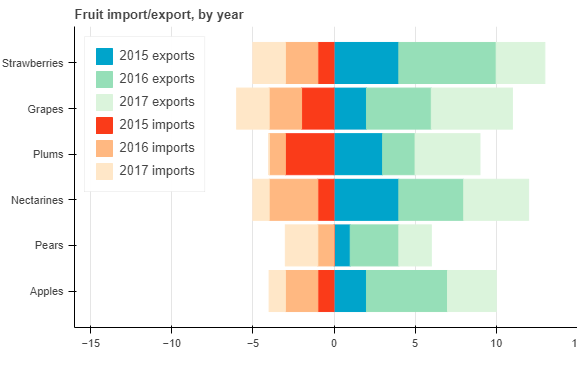